In [1]:
import torch
import glob
import numpy
from PIL import Image
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as trns
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets,transforms

In [2]:
class CNN_model(nn.Module):
    #列出需要哪些層
    def __init__(self):
        super(CNN_model, self).__init__()
        # Convolution 1 , input_shape=(3,224,224)
        self.cnn1 = nn.Conv2d(3, 16, kernel_size=5, stride=1) 
        # output_shape=((224–5+1)/(1+1)=110) (16,110,110)
        self.relu1 = nn.ReLU(inplace=True) 
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # output_shape=(16,55,55)
        # Convolution 2 , 
        self.cnn2 = nn.Conv2d(16,8, kernel_size=11, stride=1) 
        self.relu2 = nn.ReLU(inplace=True) 
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # Fully connected 1 ,#input_shape=(8*50*50)
        self.fc = nn.Linear(8 * 50 * 50, 2)     
    #列出forward的路徑，將init列出的層代入
    def forward(self, x):
        out = self.cnn1(x) 
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out) 
        return out

In [3]:
class humanDataset(Dataset):
    def __init__(self, root, split, transform):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        self.transform = transform

        # Load image path and annotations
#         mat = loadmat(f'{root}/{split}_list.mat', squeeze_me=True)
#         self.imgs = mat['file_list']
#         self.data = [f'{root}/{i}' for i in self.imgs]
    
        self.imgs = glob.glob(f'{root}/{split}/*.jpg')
        
        self.lbls = []
    
        for i in self.imgs:
            self.lbls.append(int(i.split('_')[1]))
        
            
        self.lbls = numpy.array(self.lbls, dtype='uint8')


        assert len(self.imgs) == len(self.lbls), 'mismatched length!'
        print('Total data in {} split: {}'.format(split, len(self.imgs)))


    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform)
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        imgpath = self.imgs[index]
        img = Image.open(imgpath).convert('RGB')
        lbl = int(self.lbls[index])
        if self.transform is not None:
            img = self.transform(img)
        return img, lbl

    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.imgs)

In [4]:
device = torch.device("cuda")

In [5]:
# Load model
net = CNN_model()
net.load_state_dict(torch.load("./race_model.pt"))
net.cuda()
net.eval()

CNN_model(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 8, kernel_size=(11, 11), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=20000, out_features=2, bias=True)
)

In [6]:
test_transform = trns.Compose([
    trns.Resize((224, 224)),
    trns.ToTensor(),
    trns.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
test_set = humanDataset(root='./dataset/humanDataset',
                       split='test', transform=test_transform)
test_loader = DataLoader(
    dataset=test_set, batch_size=16, shuffle=True, num_workers=0)

Total data in test split: 3250


In [8]:
# Test
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test inputs: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test inputs: 86 %


In [17]:
# !curl https://images.chinatimes.com/newsphoto/2022-07-11/656/20220711001672_20220711113037.jpg > ./taipei.jpg
# !curl https://ichef.bbci.co.uk/news/800/cpsprodpb/12A64/production/_101688367_hi046097004_2014.jpg.webp > ./president.jpg
# !curl https://upload.wikimedia.org/wikipedia/commons/c/c0/%E8%A1%9B%E7%94%9F%E7%A6%8F%E5%88%A9%E9%83%A8%E9%83%A8%E9%95%B7%E9%99%B3%E6%99%82%E4%B8%AD.jpg > ./chen.jpg
# !curl https://upload.wikimedia.org/wikipedia/commons/e/e4/%E4%B8%AD%E8%8F%AF%E6%B0%91%E5%9C%8B%E7%AC%AC12%E3%80%8113%E4%BB%BB%E7%B8%BD%E7%B5%B1%E9%A6%AC%E8%8B%B1%E4%B9%9D%E5%85%88%E7%94%9F%E5%AE%98%E6%96%B9%E8%82%96%E5%83%8F%E7%85%A7.jpg > ./horse.jpg
# !curl https://img.ltn.com.tw/Upload/news/600/2022/09/09/phpqhmksE.jpg > ./queen.jpg
# !curl https://cw1.tw/CW/images/article/201711/article-5a126186ec4df.jpg > ./Merkel.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 51872  100 51872    0     0   289k      0 --:--:-- --:--:-- --:--:--  291k


In [18]:
img1 = Image.open("./chen.jpg")
img2 = Image.open("./horse.jpg")
img3 = Image.open("./Merkel.jpg")
img4 = Image.open("./president.jpg")
img5 = Image.open("./queen.jpg")
img6 = Image.open("./taipei.jpg")
img7 = Image.open("./tomgirl.jpg")

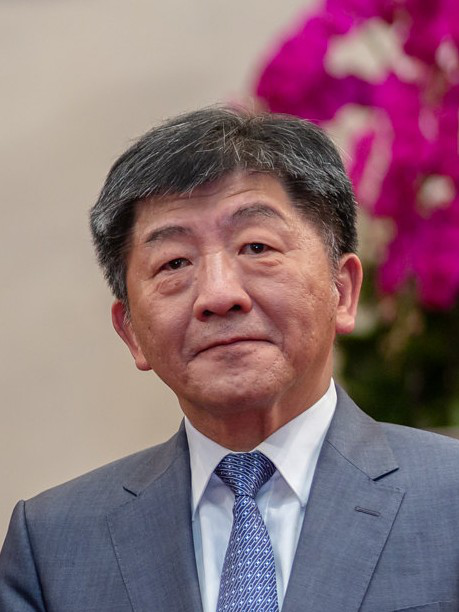

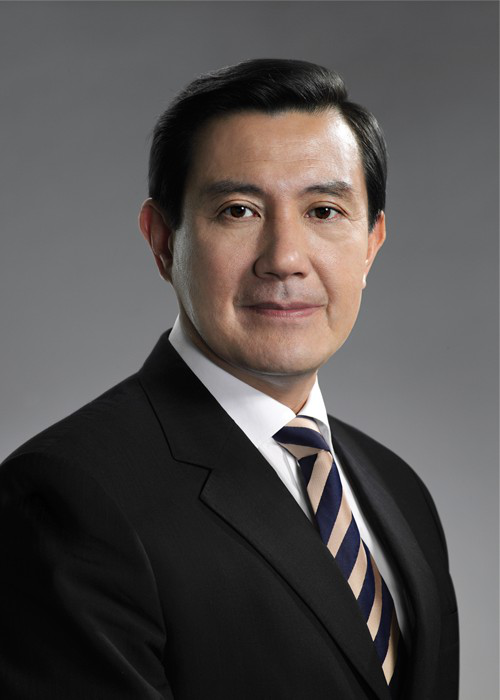

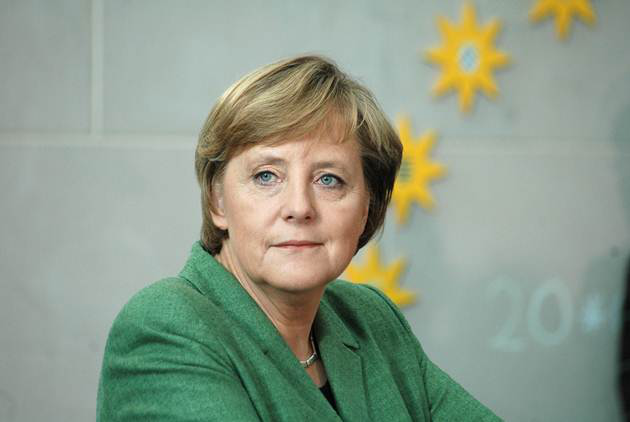

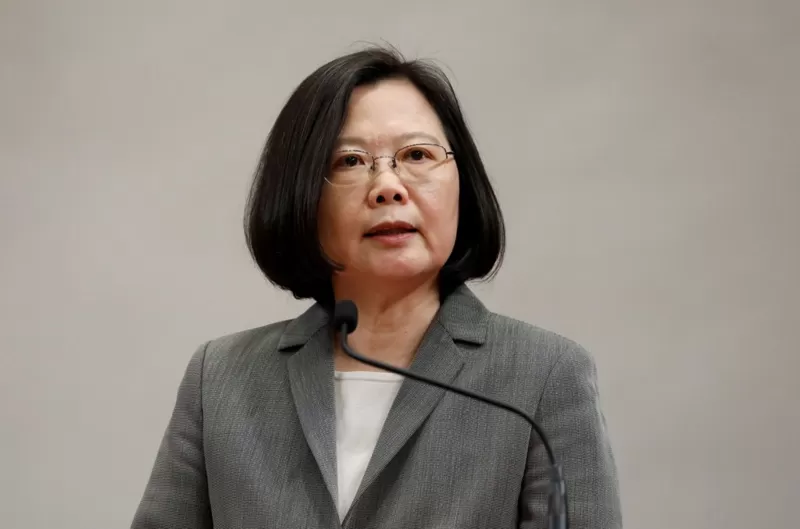

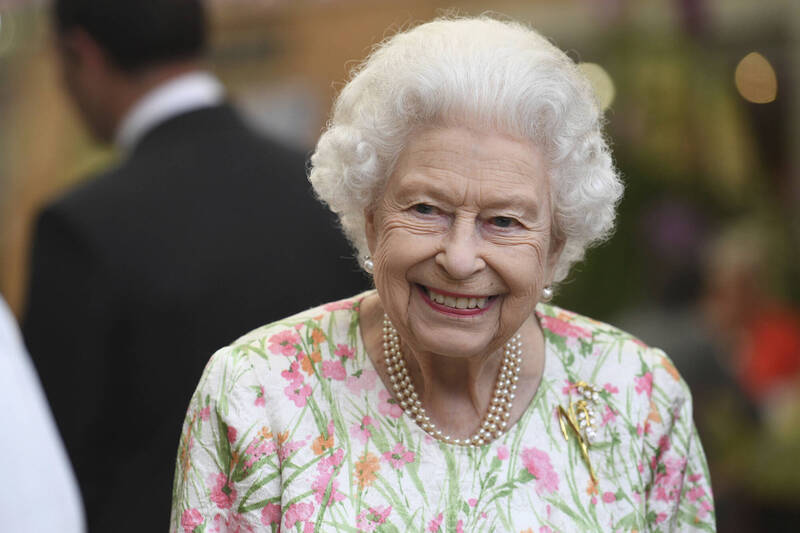

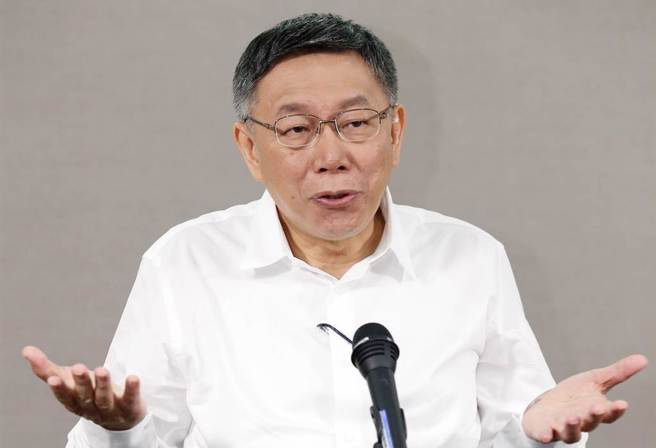

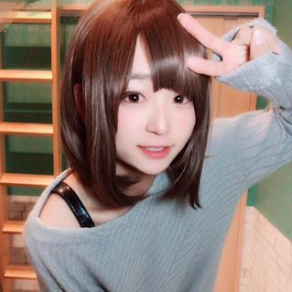

In [19]:
display(img1)
display(img2)
display(img3)
display(img4)
display(img5)
display(img6)
display(img7)

In [20]:
img1 = test_transform(img1)
img2 = test_transform(img2)
img3 = test_transform(img3)
img4 = test_transform(img4)
img5 = test_transform(img5)
img6 = test_transform(img6)
img7 = test_transform(img7)

In [21]:
img1 = img1.to(device)
img2 = img2.to(device)
img3 = img3.to(device)
img4 = img4.to(device)
img5 = img5.to(device)
img6 = img6.to(device)
img7 = img7.to(device)

In [22]:
inp_batch = torch.stack([img1, img2, img3, img4, img5, img6, img7])
out_batch = net(inp_batch)

In [23]:
print(out_batch)

tensor([[ 1.3712, -1.3688],
        [ 1.9268, -1.8506],
        [-0.7826,  0.7813],
        [-1.5043,  1.4863],
        [ 0.4704, -0.6718],
        [ 0.7368, -0.8013],
        [ 0.3245, -0.1484]], device='cuda:0', grad_fn=<AddmmBackward0>)
